# Visualise feature set distributions

The purpose of this notebook is to visualise the distribution of feature set values. For each feture set, I will produce a plot showing the relative porpotions of values:
1. for all patients, 
2. for cases, _and_
3. for controls.

For logic-valued feature sets  - i.e. {True, False} - and categoriecal feature sets, I will use horizontal bar charts, with proportions for all patients at the top, then cases, then controls.

For continuous-valued feature sets, I will use histograms with feature-set-specific bin widths, with the histogram for all patients in the background, for caseses in the midground, and for controls in the foreground.

## Imports and helper functions

In [1]:
%run 'UNSEEN_helper_functions.ipynb'
%store -r

## Retrieve all feature sets that are boolean (i.e. True/False for the presence of the feature set)

In [2]:
fs_boolean = feature_set_array.loc[:,feature_set_array.dtypes == 'bool']

## Apply redaction and rounding rules to avoid disclosivity.


In [3]:
# Display message.
display(
    Markdown(
f"""
Any feature set with a category count less than or equal to {redaction_threshold} are redacted. All remaining feature-set category counts are rounded to the nearest {target_round}.
"""
       )
)
# Redaction.
fs_redacted = fs_boolean.loc[:,fs_boolean.sum() > redaction_threshold]
# Rounding.
denominator_overall = round(len(caseness_array) / target_round) * target_round
denominator_caseness = round(sum(caseness_array.caseness_1isYes == 1) / target_round) * target_round
denominator_controls = round(sum(caseness_array.caseness_1isYes != 1) / target_round) * target_round
# NOTE: numerators will be rounded during the data-processing steps of the visualisation.


Any feature set with a category count less than or equal to 7 are redacted. All remaining feature-set category counts are rounded to the nearest 10.


## Retrieve all feature sets that are boolean (i.e. True/False for the presence of the feature set)

The code below accepts a pandas.DataFrame of feature-set values and produces a 3-part visualisation for each:
1. A column chart showing the proportions of patients with each of the categorical feature-set values, colour coded by patient group.
2. A column chart showing the proportions of patients within each of the patient groups, colour coded by feature set value.
3. A table showing the proportions of patients in each patient group that have each feature-set value. Rows sum to 1.00.

In [4]:
# Instantiate variables.
myPlotDataOverall = []
myPlotDataCaseness = []
myPlotDataControls = []

# Set save location.
plot_dir = pathlib.Path(os.getcwd() + '/Plots/Descriptives/')

for i_col in range(len(fs_redacted.columns)):
    # Get set of values that are in the column.
    colVals = fs_redacted.iloc[:,i_col].unique()
    
    # Count the occurence of each unique value, overall.
    ls_vals = []
    for i_val in colVals:
        ls_vals.append(
            round(
                # Rounding to avoid disclosivity.
                round( sum(fs_redacted.iloc[:,i_col] == i_val) / target_round) * target_round
                / denominator_overall
                , 2
            )
        )
    myPlotDataOverall.append(ls_vals)
    
    # Count the occurence of each unique value, for cases and for controls.
    ls_vals_caseness = []
    ls_vals_controls = []
    for i_val in colVals:
        fs_present = fs_redacted.iloc[:,i_col] == i_val
        caseness_present = caseness_array.caseness_1isYes == 1
        combined = pandas.concat([fs_present, caseness_present], axis = 1)
        ls_vals_caseness.append(
            round(
                # Rounding to avoid disclosivity.
                round( sum(combined.sum(axis=1) == 2) / target_round) * target_round
                / denominator_caseness
                , 2
            )
        )
        
        control_present = caseness_array.caseness_1isYes != 1
        combined = pandas.concat([fs_present, control_present], axis = 1)
        ls_vals_controls.append(
            round(
                round( sum(combined.sum(axis=1) == 2) / target_round) * target_round 
                / denominator_controls
                , 2
            )
        )
    myPlotDataCaseness.append(ls_vals_caseness)
    myPlotDataControls.append(ls_vals_controls)

# Combine each feature sets' tuples from the 'overall', 'caseness', and 'controls' plot data.
myData = list(map(list, zip(*[ myPlotDataOverall, myPlotDataCaseness, myPlotDataControls ])))

# Plot the visualisations for each feature set
for i_fs in range(len(fs_redacted.columns)):
    fig, axs = matplotlib.pyplot.subplots(1, 3, figsize = (12,4),  gridspec_kw={'width_ratios': [2, 2, 3]})
    matplotlib.pyplot.title('Feature set is\n\'' + fs_redacted.columns[i_fs] + '\'', fontsize = 20)
    # Plot distinguishing cohorts.
    ind1 = ('False', 'True')
    axs[0].bar(x = ind1, height = myData[i_fs][0], width = 0.6,   align='center')
    axs[0].bar(x = ind1, height = myData[i_fs][1], width = -0.2,  align='edge')
    axs[0].bar(x = ind1, height = myData[i_fs][2], width = 0.2,   align='edge')
    axs[0].legend(['All patients', 'Cases', 'Controls'])
    axs[0].set_xlabel('Feature set value')
    axs[0].set_ylabel('Proportion of patients')
    axs[0].set_ylim(0,1.2)
    
    # Plot distinguishing feature-set values.
    ind2 = ('All patients', 'Cases', 'Controls')
    axs[1].bar(x = ind2, height = list(map(list, zip(*myData[i_fs])))[0], width = -0.2,  align='edge')
    axs[1].bar(x = ind2, height = list(map(list, zip(*myData[i_fs])))[1], width = 0.2,   align='edge')
    axs[1].legend(['False', 'True'])
    axs[1].set_xlabel('Patient group')
    axs[1].set_ylabel('Proportion of patients')
    axs[1].set_ylim(0,1.2)

    collabel = ('All patients', 'Cases', 'Controls')
    the_table = axs[2].table(cellText = list(map(list, zip(*myData[i_fs]))),
                          colLabels = ind2,
                          rowLabels = ind1,
                          loc = 'center')
    the_table.scale(1,2)
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(15)
    axs[2].axis('off')
    matplotlib.pyplot.tight_layout()
    
    # Save figures.
    fig.savefig(f'{plot_dir}/{fs_redacted.columns[i_fs]}.png')
    matplotlib.pyplot.close(fig)

# Show plots

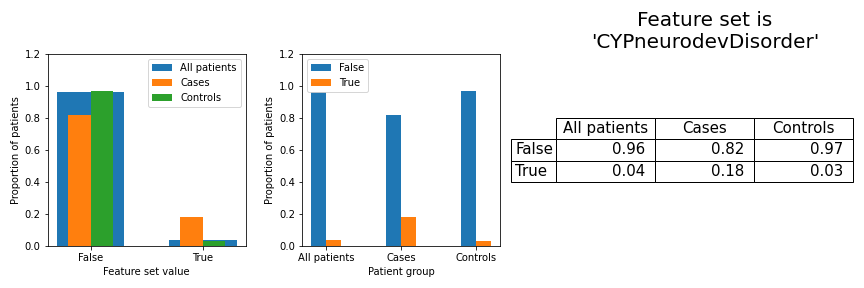

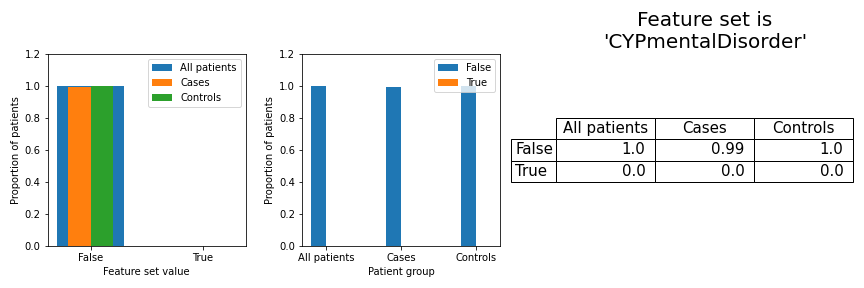

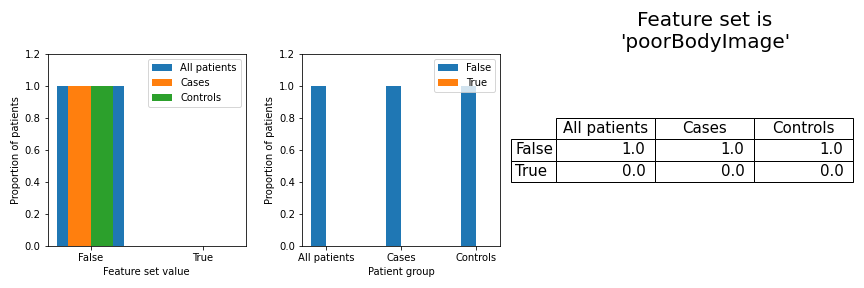

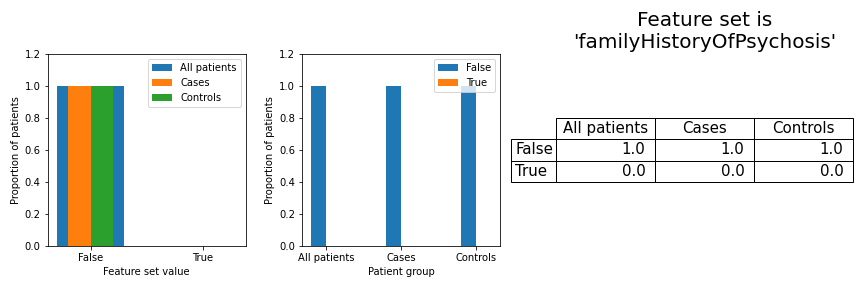

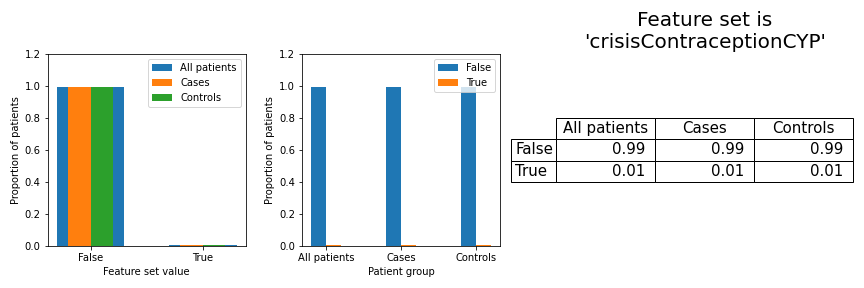

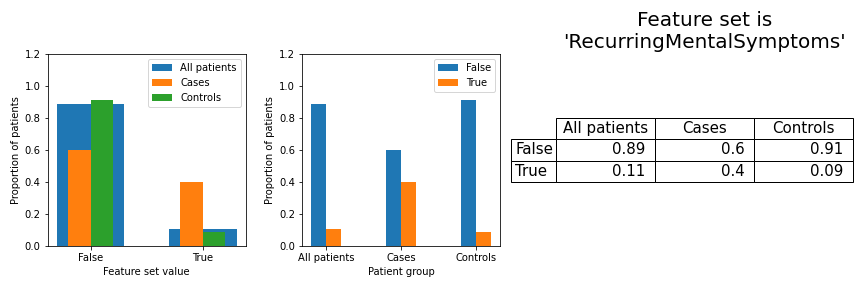

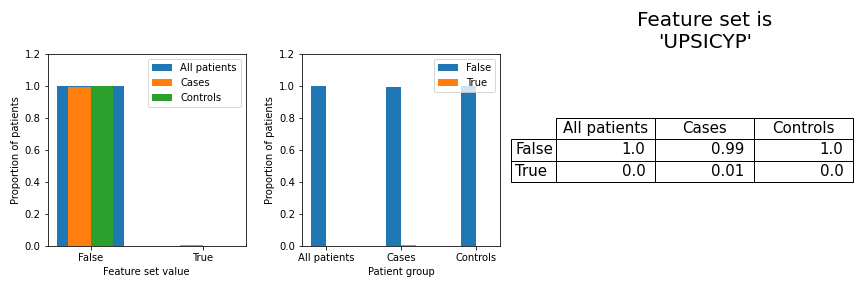

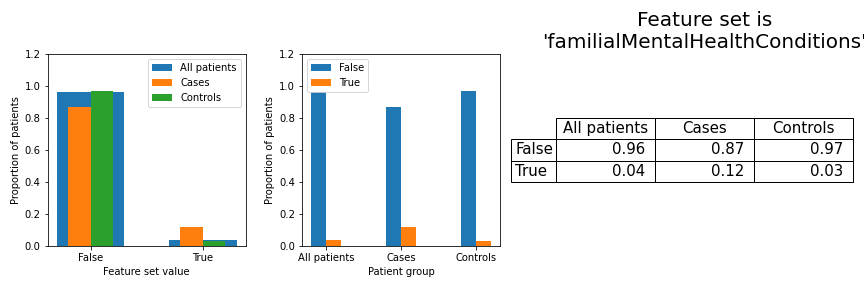

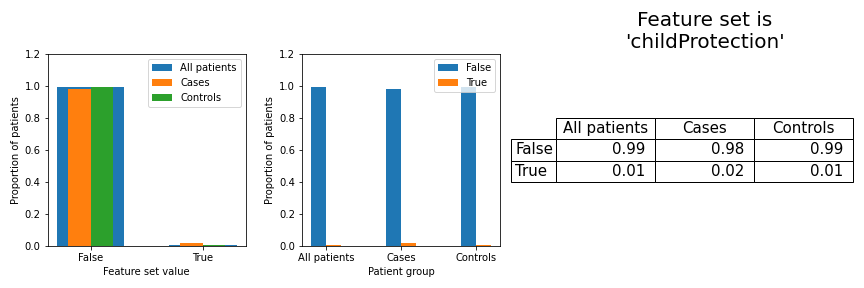

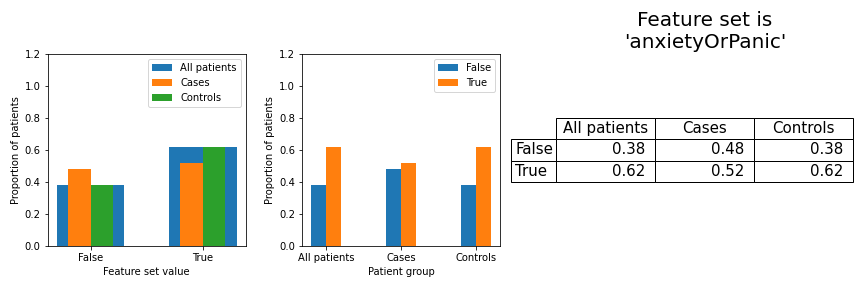

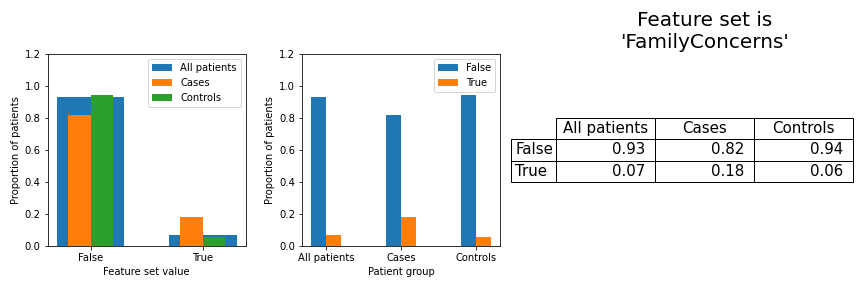

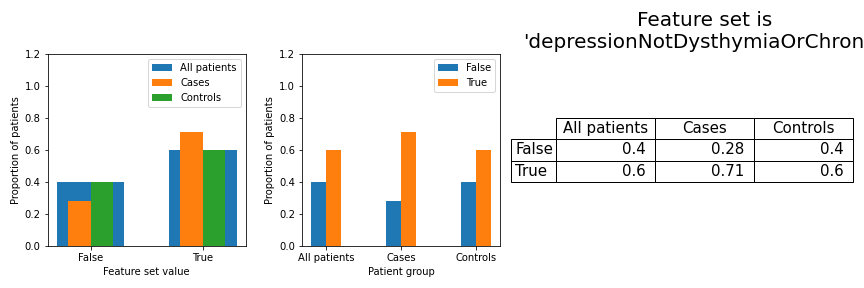

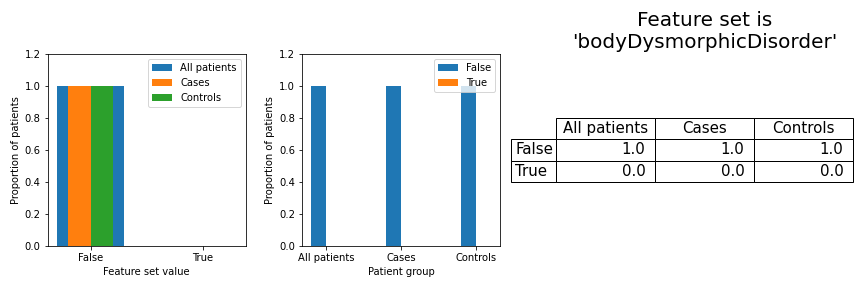

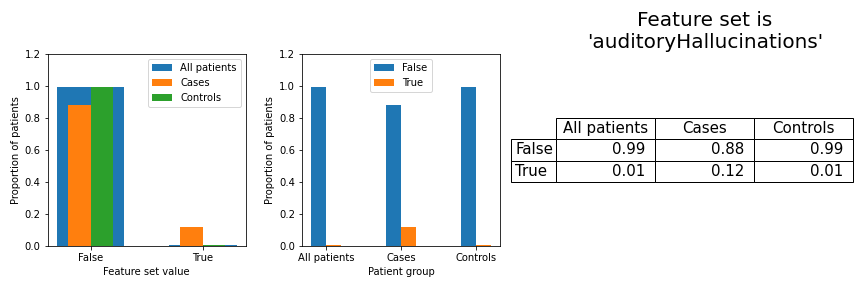

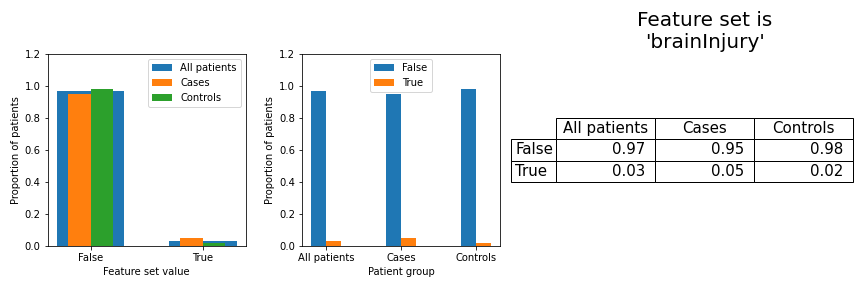

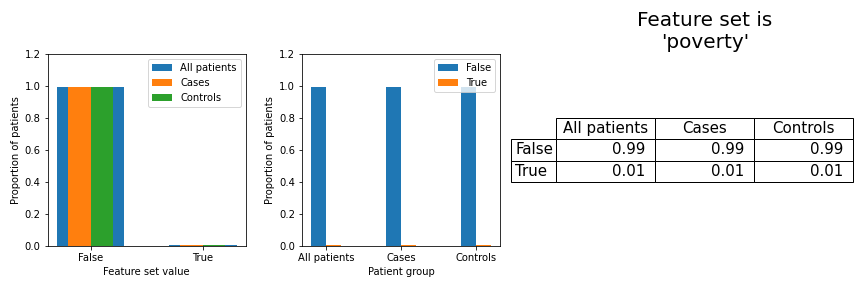

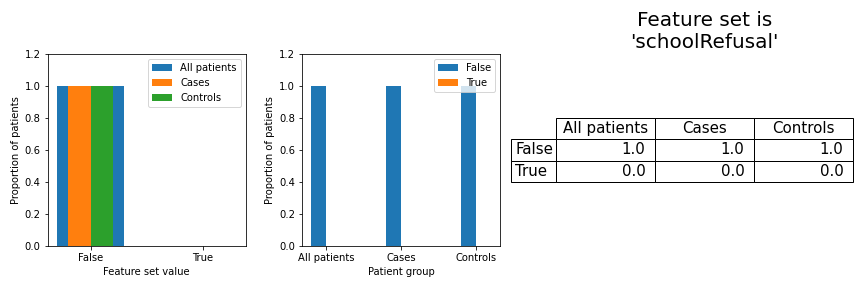

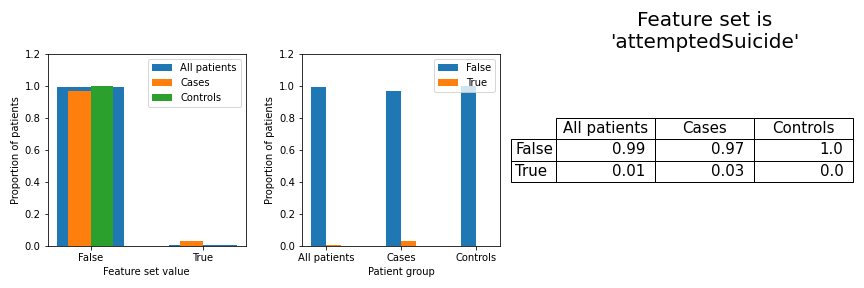

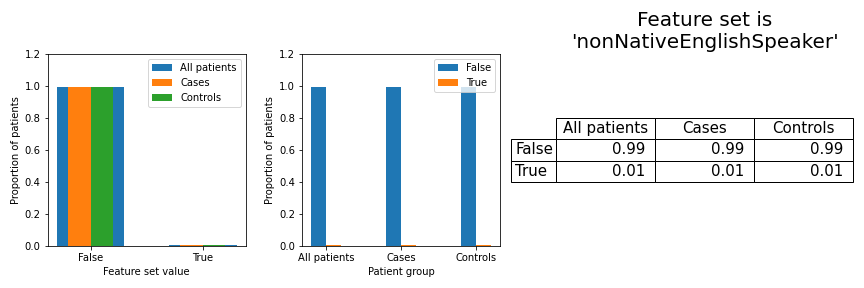

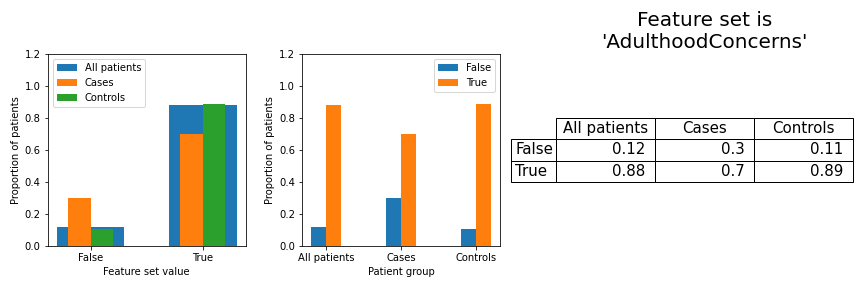

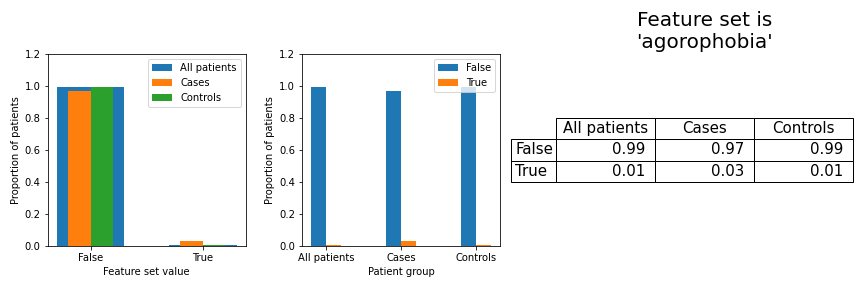

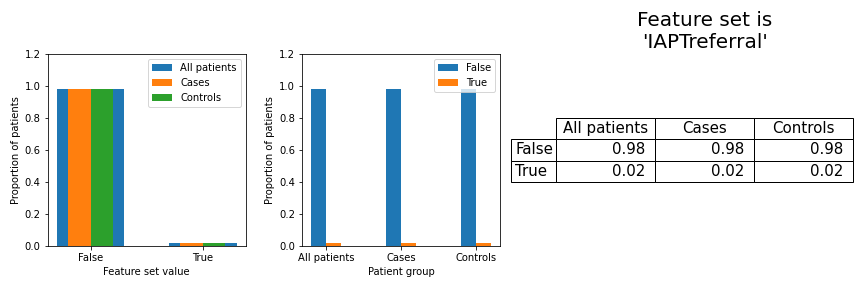

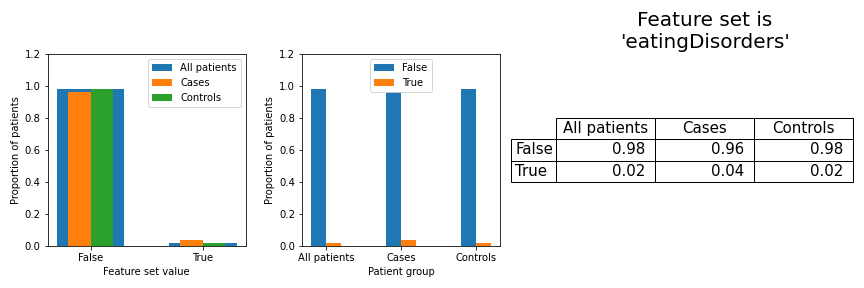

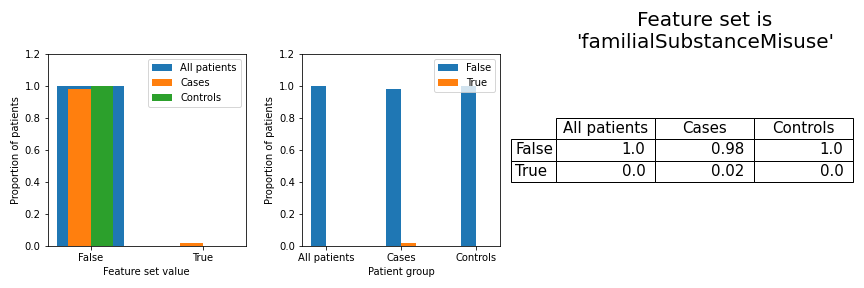

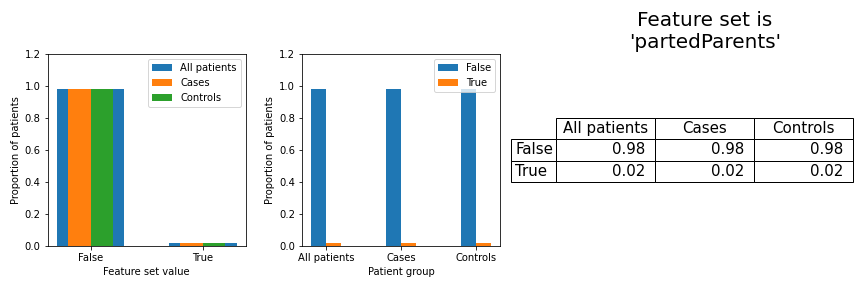

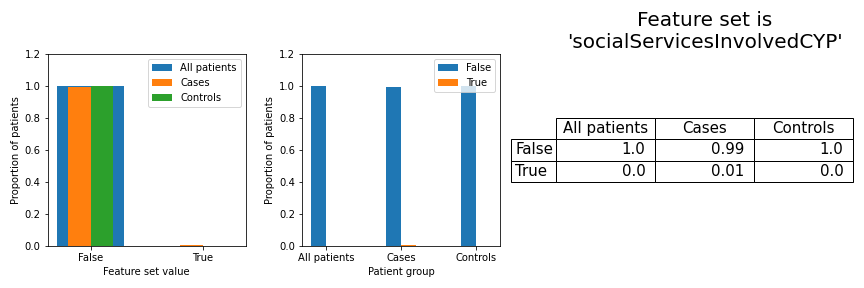

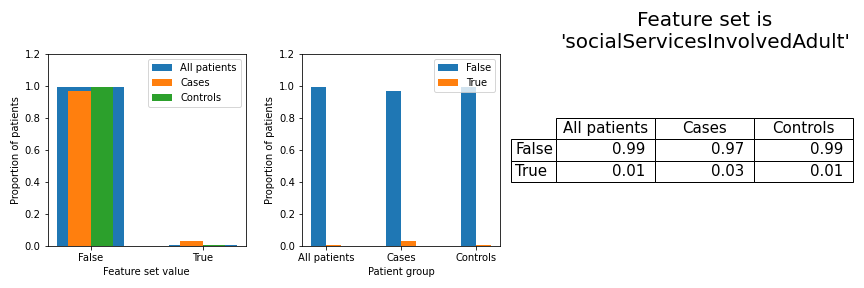

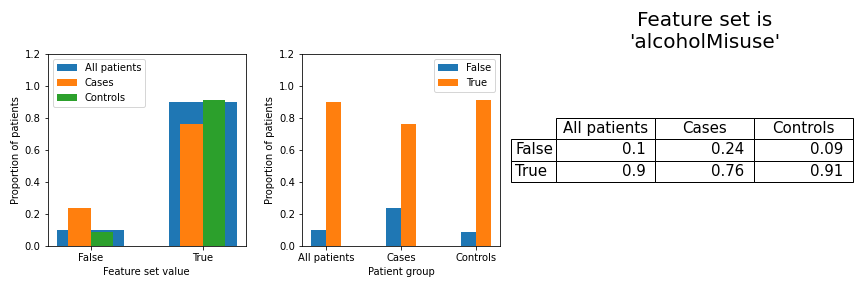

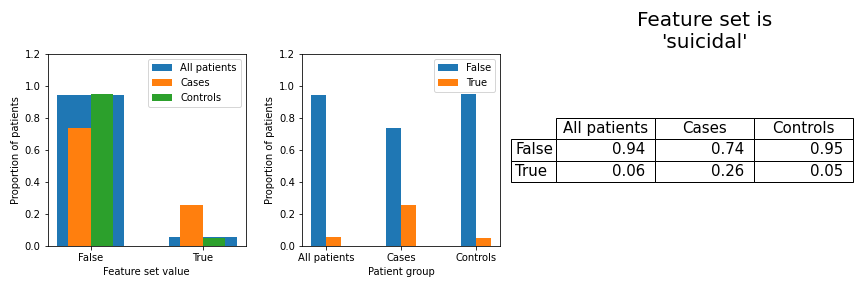

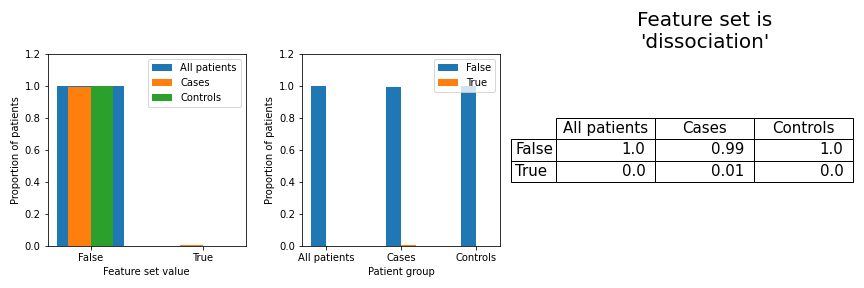

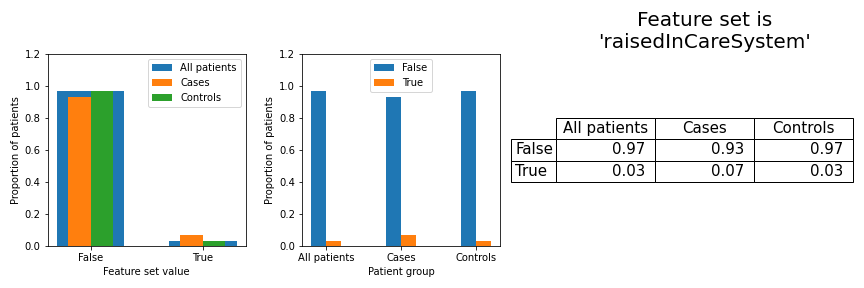

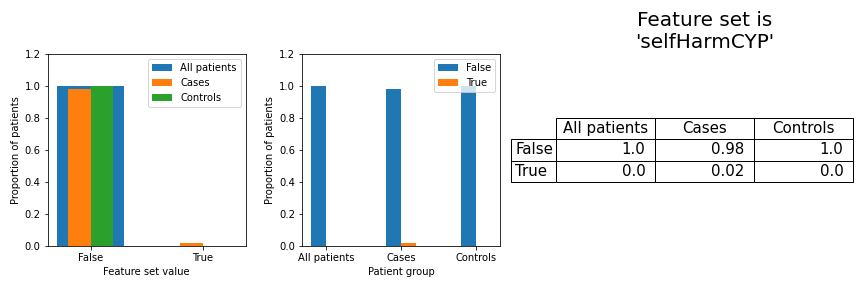

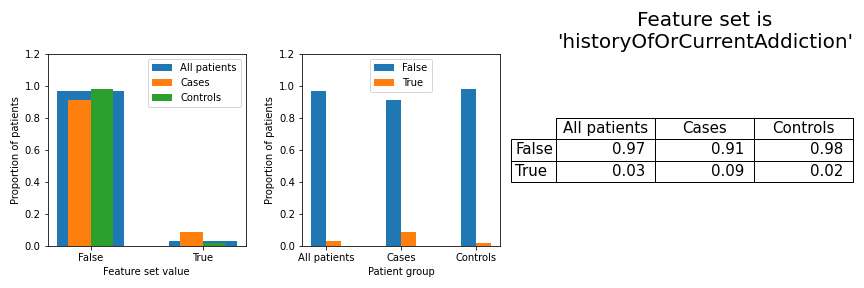

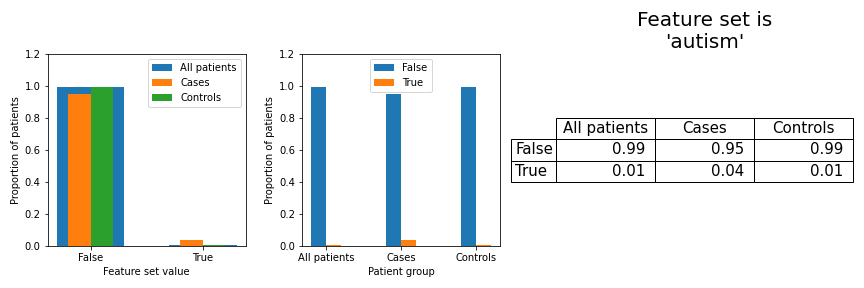

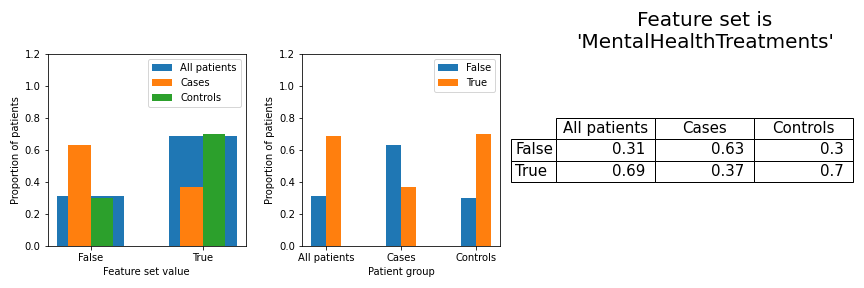

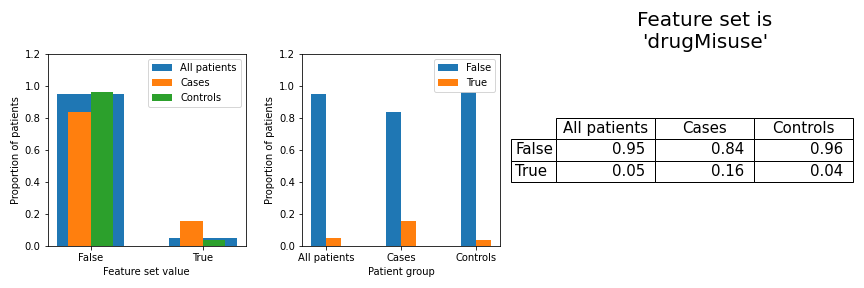

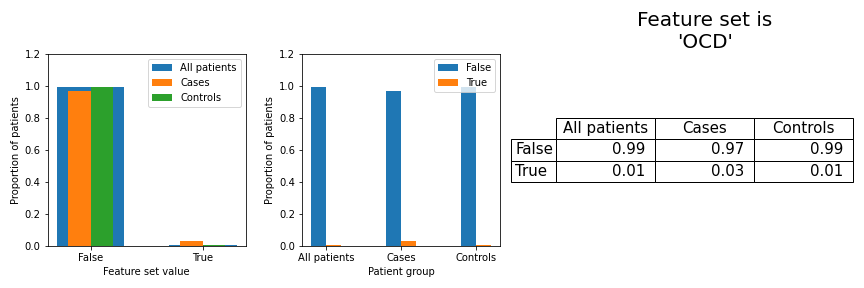

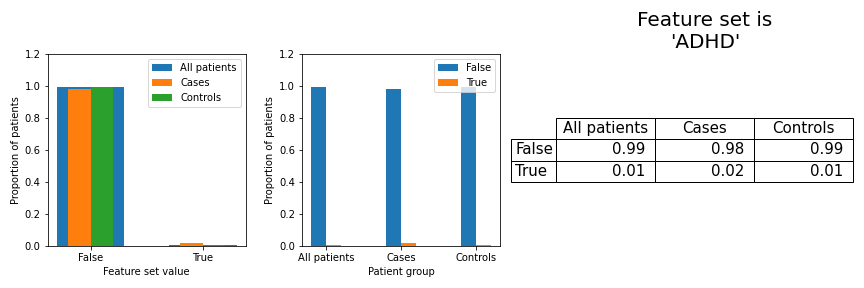

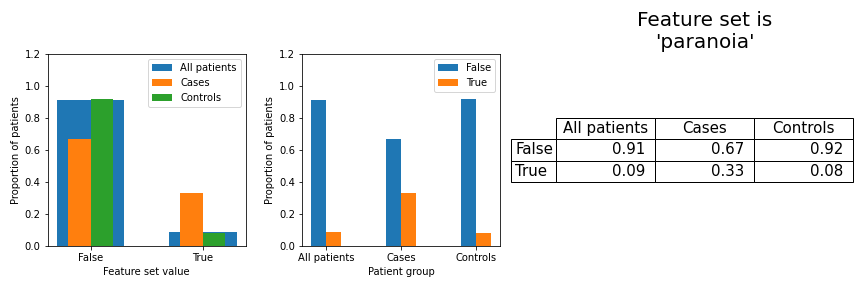

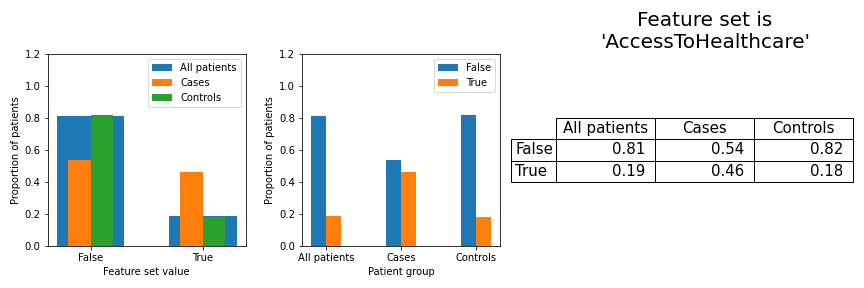

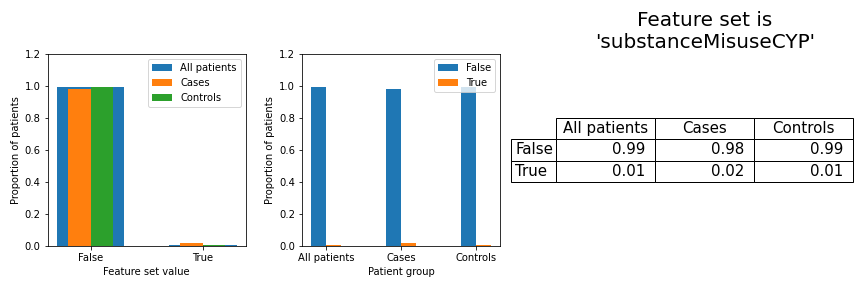

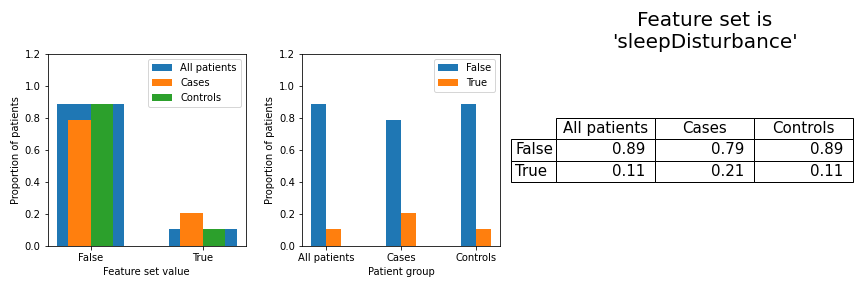

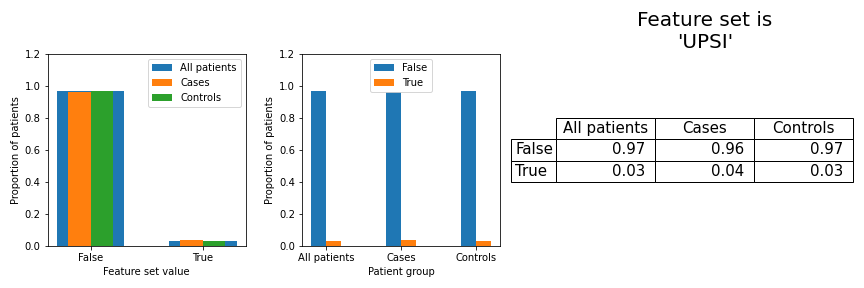

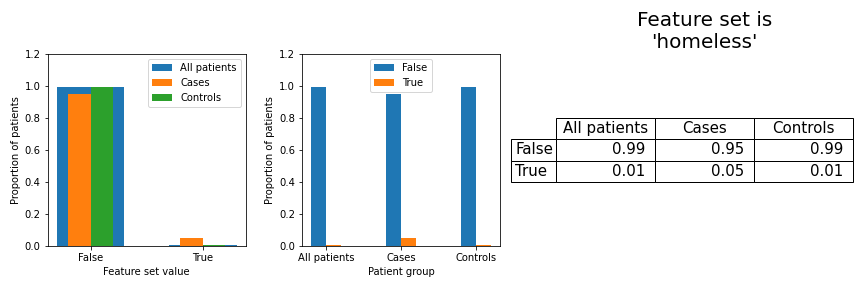

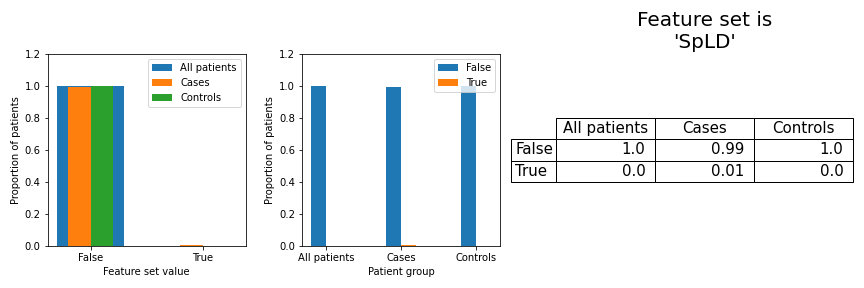

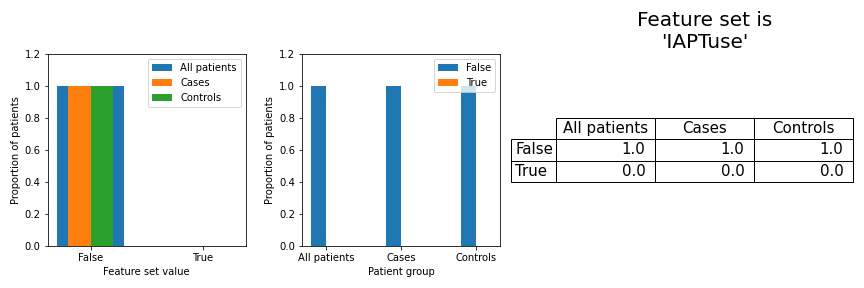

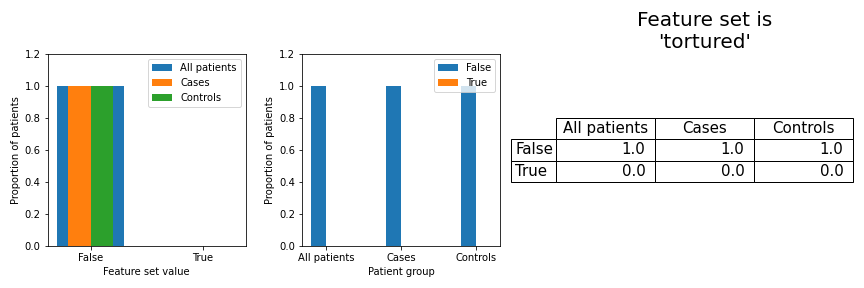

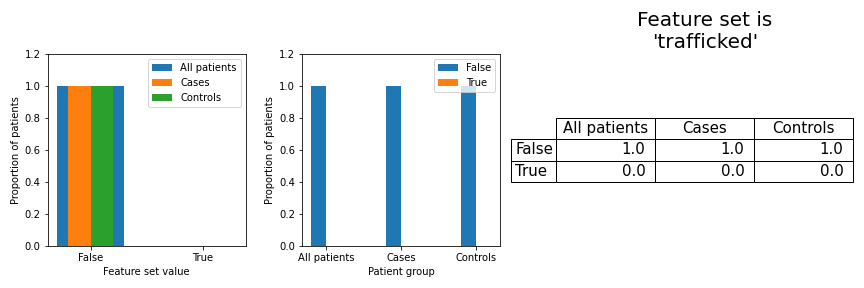

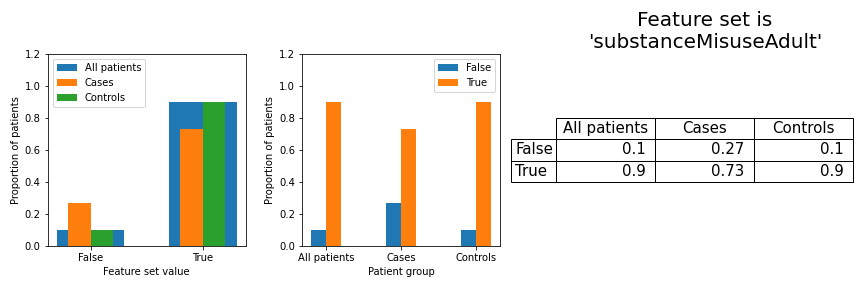

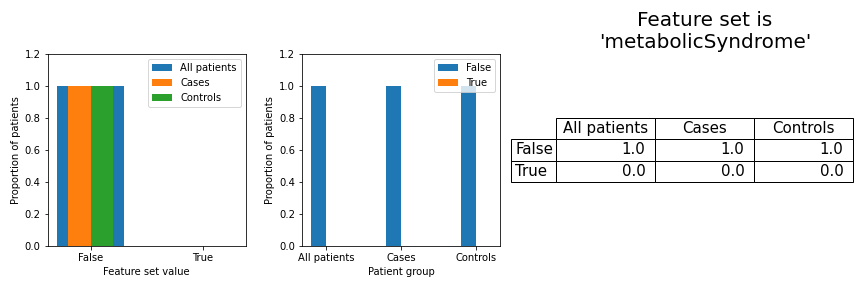

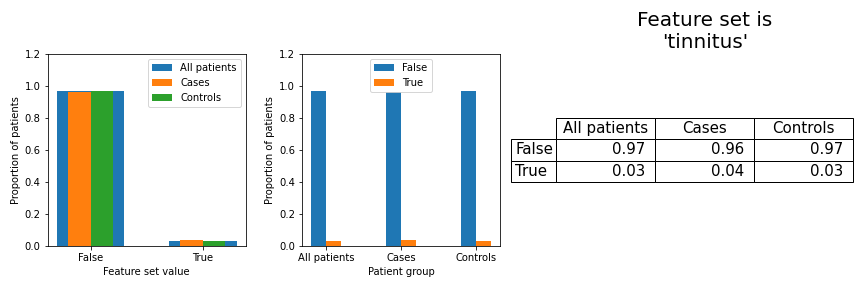

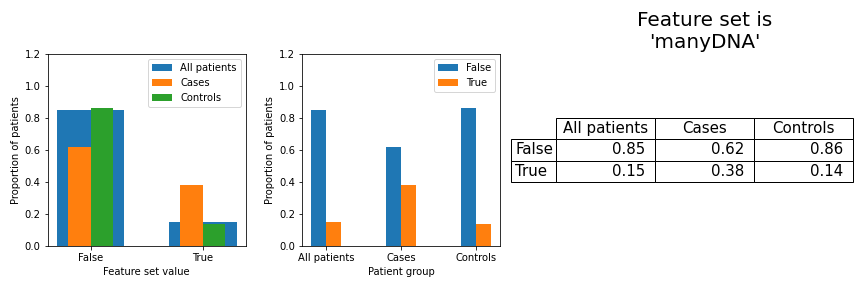

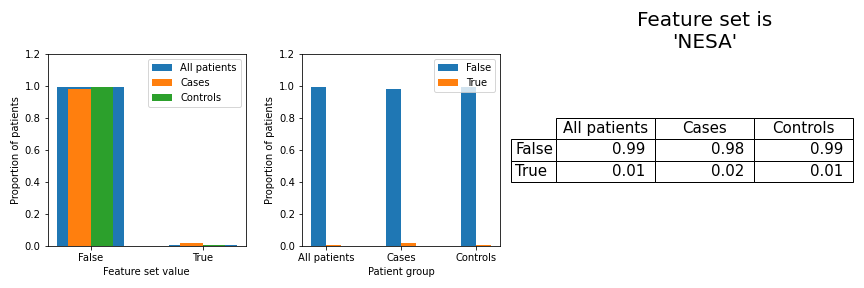

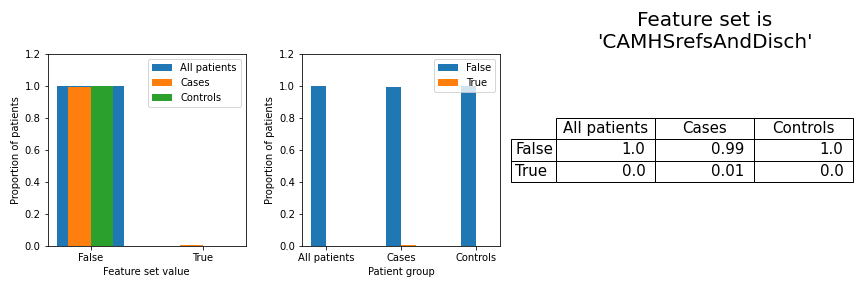

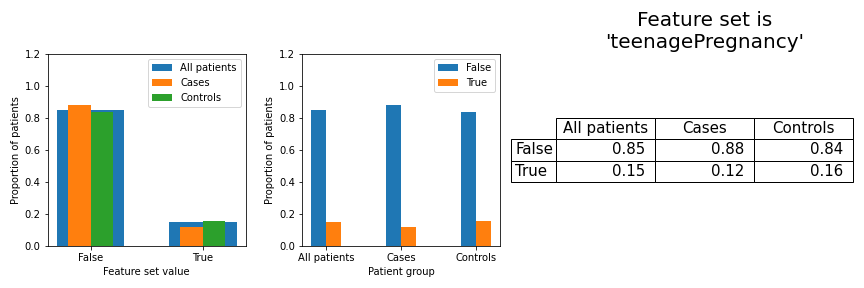

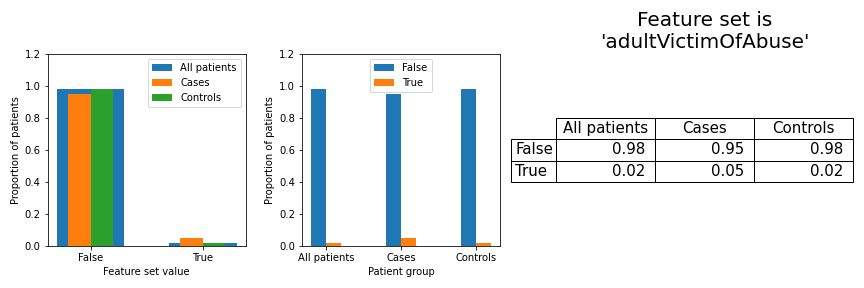

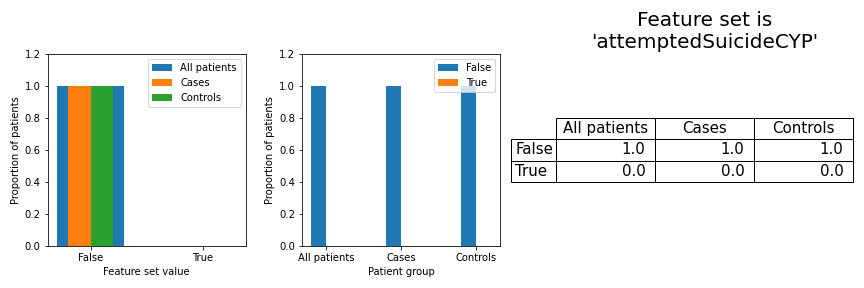

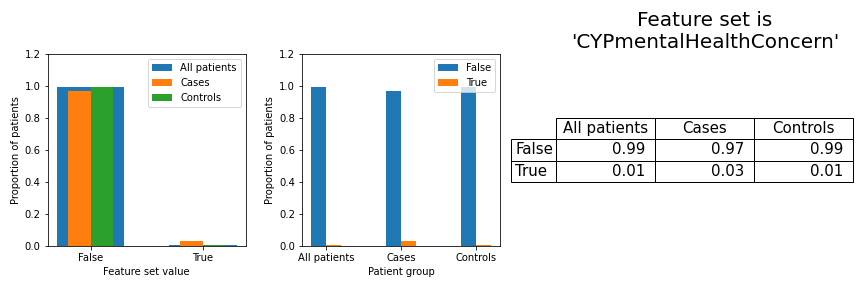

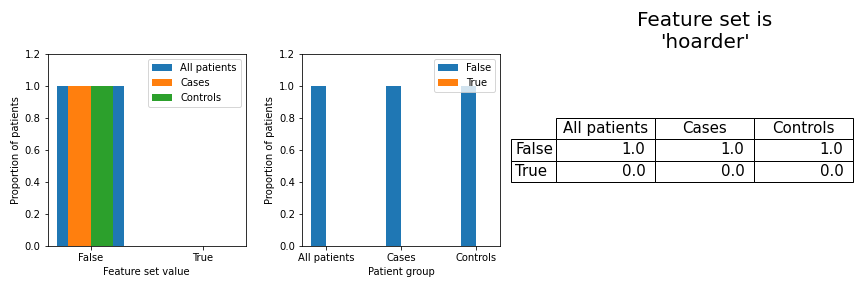

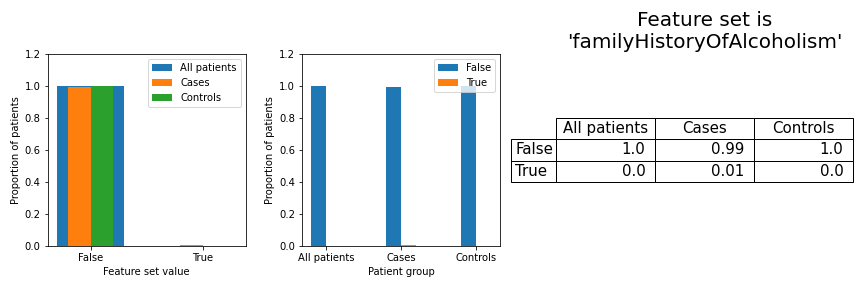

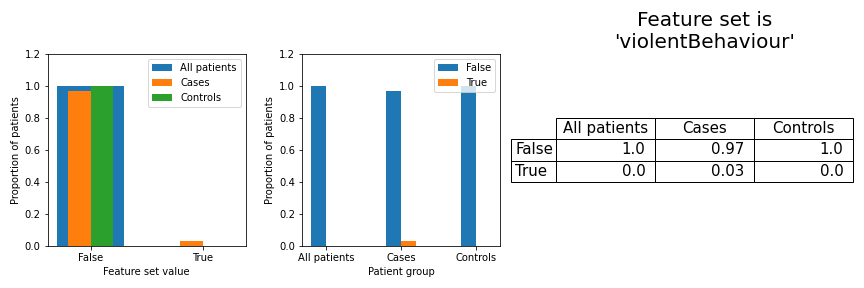

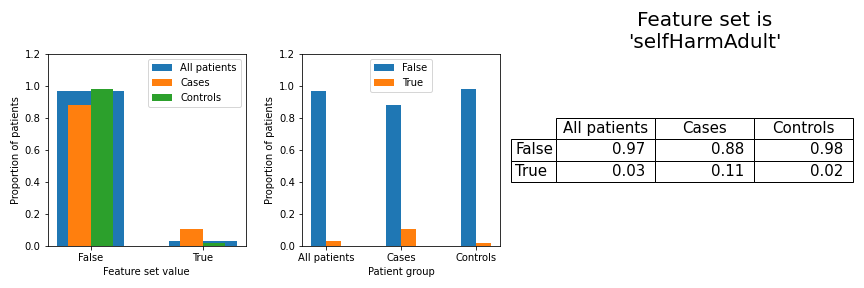

In [5]:
# Create a list of all relevant files.
globbed_files = plot_dir.glob("*.png")
# Plot each file.
for image_file in globbed_files:
    display(Image(filename=image_file))